In [1]:
import sys
from pathlib import Path

IS_COLAB = "google.colab" in sys.modules
IS_KAGGLE = "kaggle_secrets" in sys.modules
if IS_KAGGLE:
    repo_path = Path("../input/microstructure-reconstruction")
elif IS_COLAB:
    from google.colab import drive

    drive.mount("/content/gdrive")
    repo_path = Path("/content/gdrive/MyDrive/microstructure-reconstruction")
else:
    repo_path = Path("/home/matias/microstructure-reconstruction")
sys.path.append(str(repo_path))

import re
from copy import deepcopy
from importlib import reload

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pytorch_lightning as pl
import seaborn as sns
import torch
import torch.nn as nn
import torch.optim as optim
import torchmetrics
import torchvision.models as pretrained_models
import wandb
from custom_datasets import datasets
from custom_models import cnns
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KernelDensity
from sklearn.preprocessing import MinMaxScaler
from tools import dataframe_reformat, inspect_code, plotting, training, wandb_api
from torch.utils.data import DataLoader
from torchvision import transforms, utils
from tqdm import tqdm

wandb_api.login()
api = wandb.Api()
run_name = "2t5wl4m1"
run = api.run(f"matiasetcheverry/microstructure-reconstruction/{run_name}")
config = run.config

use_cuda = torch.cuda.is_available()
config["device"] = torch.device("cuda" if use_cuda else "cpu")
kwargs = {"num_workers": 2, "pin_memory": True} if use_cuda else {"num_workers": 4}
print(f"[INFO]: Computation device: {config['device']}")


Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: matiasetcheverry. Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /home/matias/.netrc


[INFO]: Computation device: cpu


In [2]:
run = api.run(f"matiasetcheverry/microstructure-reconstruction/{run_name}")
root_path = Path("tmp/")

def execute_script(script):
    model_script = run.file(f"{script}_script.txt")
    model_script = model_script.download(root=root_path / run.name, replace=True)
    model_script.seek(0)
    model_name = re.findall(r"(?<=class ).[a-zA-Z0-9_.-]*", model_script.read())[0]
    model_script.seek(0)
    return model_name, open(model_script.name, "r")

model_name, model_file = execute_script("model")
exec(model_file.read())
datamodule_name, datamodule_file = execute_script("datamodule")
exec(datamodule_file.read())
encoder_name, encoder_file = execute_script("encoder")
exec(encoder_file.read())
decoder_name, decoder_file = execute_script("decoder")
exec(decoder_file.read())

checkpoint = run.file("last.ckpt")
checkpoint.download(root=root_path / run.name, replace=True)

<_io.TextIOWrapper name='tmp/polished-pine-748/last.ckpt' mode='r' encoding='UTF-8'>

In [3]:
dm = eval(datamodule_name)(config=config, repo_path=repo_path)
model = eval(model_name).load_from_checkpoint(
    root_path / run.name / checkpoint.name, config=run.config
)
trainer = pl.Trainer(devices="auto", accelerator="auto")
raw_predictions = trainer.predict(model, datamodule=dm)
predictions = torch.cat([i[0] for i in raw_predictions])
latent_representation = predict = torch.cat([i[2] for i in raw_predictions])
targets = torch.cat([img for img, _ in dm.val_dataloader()])
descriptors = torch.cat([desc for _, desc in dm.val_dataloader()])


/home/matias/.pyenv/versions/3.9.8/envs/gt/lib/python3.9/site-packages/pytorch_lightning/loops/utilities.py:91: PossibleUserWarning: `max_epochs` was not set. Setting it to 1000 epochs. To train without an epoch limit, set `max_epochs=-1`.
  rank_zero_warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: 0it [00:00, ?it/s]

In [4]:
predictions.shape, targets.shape, descriptors.shape, latent_representation.shape

(torch.Size([180, 3, 64, 64]),
 torch.Size([180, 3, 64, 64]),
 torch.Size([180, 25]),
 torch.Size([180, 5]))

In [5]:
descriptors_df = pd.DataFrame(descriptors, columns=dm.train_df.columns[1:-1])
latent_representation_df = pd.DataFrame(
    latent_representation,
    columns=[f"latent_{i}" for i in range(latent_representation.shape[1])],
)
latent_representation_df


,latent_0,latent_1,latent_2,latent_3,latent_4
0,1.915512,0.037860,-1.016722,0.412874,0.855838
1,-2.718717,0.251790,-0.412765,1.284786,1.873818
2,3.380730,-1.841907,-0.382655,-0.773245,0.185370
3,3.526073,-0.631896,-0.749066,-0.491343,-0.405500
4,3.371271,-0.946700,-1.838539,0.115286,0.781159
...,...,...,...,...,...
175,2.913256,-1.285415,-0.663468,0.383030,-0.358967
176,-2.899348,1.804238,0.431579,0.304940,0.409956
177,0.324645,0.137056,-0.122715,0.017662,-1.002017
178,1.313921,-0.289698,0.844105,0.167959,-1.854082


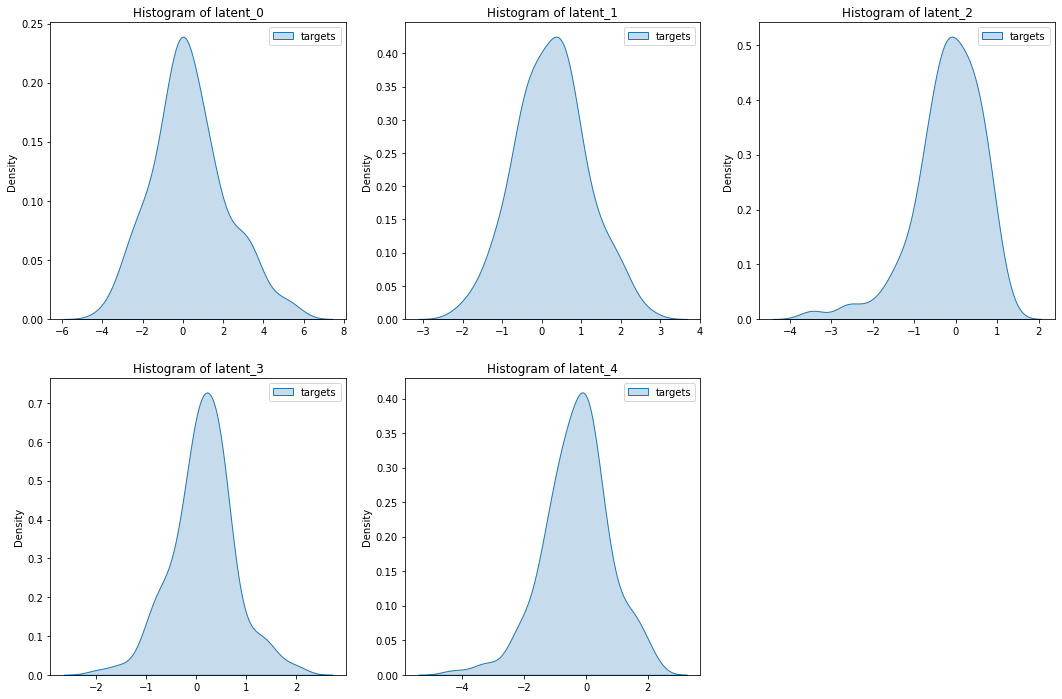

In [9]:
fig, ax = plotting.plot_kde([latent_representation_df], nb_hist_per_line=3)

In [10]:
df = pd.concat([descriptors_df, latent_representation_df,], axis=1)
df

,nearest_distance_mean,nearest_distance_std,orientation-0_mean,orientation-1_mean,orientation-2_mean,orientation-3_mean,orientation-4_mean,orientation-5_mean,orientation-0_std,orientation-1_std,...,solidity_mean,solidity_std,roundness_mean,roundness_std,volume_fraction,latent_0,latent_1,latent_2,latent_3,latent_4
0,0.106709,0.122068,0.658552,0.635057,0.326962,0.107960,0.423347,0.541197,0.841397,0.844440,...,0.082338,0.753458,0.017476,0.061523,0.670966,1.915512,0.037860,-1.016722,0.412874,0.855838
1,0.626408,0.547785,0.247322,0.235274,0.748895,0.946477,0.503872,0.467956,0.372610,0.322102,...,0.623210,0.495595,0.416413,0.550063,0.012615,-2.718717,0.251790,-0.412765,1.284786,1.873818
2,0.058520,0.074588,0.679301,0.639608,0.313703,0.151053,0.513966,0.315722,0.852996,0.846092,...,0.054110,0.820084,0.012156,0.130648,0.826718,3.380730,-1.841907,-0.382655,-0.773245,0.185370
3,0.081962,0.069736,0.685357,0.639446,0.310599,0.128148,0.494617,0.612428,0.872771,0.834171,...,0.012983,0.913920,0.051722,0.196676,0.846290,3.526073,-0.631896,-0.749066,-0.491343,-0.405500
4,0.209632,0.058392,0.633222,0.651281,0.331953,0.112318,0.150001,0.704495,0.844848,0.849862,...,0.490067,0.858936,0.429441,0.634256,0.824919,3.371271,-0.946700,-1.838539,0.115286,0.781159
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
175,0.101540,0.107995,0.636320,0.687226,0.311845,0.124506,0.330238,0.633779,0.834888,0.865538,...,0.016424,0.899179,0.028121,0.137394,0.795984,2.913256,-1.285415,-0.663468,0.383030,-0.358967
176,0.785648,0.657940,0.782691,0.662438,0.247555,0.921348,0.499442,0.628166,0.758583,0.770140,...,0.617856,0.465074,0.426206,0.673603,0.010278,-2.899348,1.804238,0.431579,0.304940,0.409956
177,0.076105,0.101486,0.645067,0.644896,0.329001,0.091009,0.336590,0.580131,0.846167,0.880551,...,0.247545,0.164719,0.057638,0.134675,0.481362,0.324645,0.137056,-0.122715,0.017662,-1.002017
178,0.083779,0.107326,0.634429,0.654139,0.329849,0.066684,0.348688,0.617632,0.855334,0.864309,...,0.210136,0.324483,0.053662,0.157907,0.639369,1.313921,-0.289698,0.844105,0.167959,-1.854082


/tmp/ipykernel_2720/3778709492.py:19: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


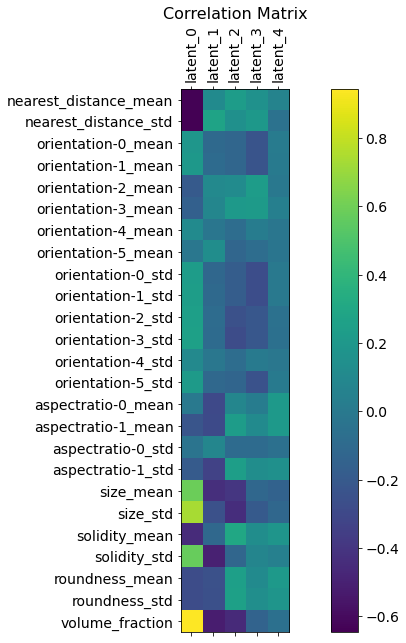

In [11]:
fig, ax = plt.subplots(figsize=(15, 10))
corr = df.corr().iloc[:25, 25:]
img = ax.matshow(corr)
ax.set_xticks(range(corr.select_dtypes(["number"]).shape[1]))
ax.set_xticklabels(
    corr.select_dtypes(["number"]).columns,
    fontsize=14,
    rotation=90,
)
ax.set_yticks(range(corr.select_dtypes(["number"]).shape[0]))
ax.set_yticklabels(
    corr.select_dtypes(["number"]).index,
    fontsize=14,
)
cb = plt.colorbar(img, ax=ax)
cb.ax.tick_params(labelsize=14)
ax.set_title("Correlation Matrix", fontsize=16)

fig.show()
